# Shapelet Discovery

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import stumpy

In [3]:
from datetime import datetime
import time

In [4]:
train = pd.read_csv("labelled_training_data.csv")

In [5]:
testing = pd.read_csv("labelled_testing_data.csv")
val = pd.read_csv("labelled_validation_data.csv")

In [6]:
data = pd.concat([train, testing, val])

In [7]:
data = data.sort_values(by=['timestamp'])

In [8]:
data = data.set_index("timestamp")

In [9]:
data.columns

Index(['processId', 'threadId', 'parentProcessId', 'userId', 'mountNamespace',
       'processName', 'hostName', 'eventId', 'eventName', 'stackAddresses',
       'argsNum', 'returnValue', 'args', 'sus', 'evil'],
      dtype='object')

In [10]:
data

,processId,threadId,parentProcessId,userId,mountNamespace,processName,hostName,eventId,eventName,stackAddresses,argsNum,returnValue,args,sus,evil
timestamp,,,,,,,,,,,,,,,
124.439221,381,381,1,101,4026532232,systemd-resolve,ip-10-100-1-129,41,socket,"[139913106282763, 139913103116537, 94901962555...",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
124.439751,378,378,1,100,4026532231,systemd-network,ip-10-100-1-129,41,socket,"[140343254628619, 93967981149065, 93967990898192]",3,15,"[{'name': 'domain', 'type': 'int', 'value': 'A...",0,0
124.439958,1,1,0,0,4026531840,systemd,ip-10-100-1-129,1005,security_file_open,"[140074839310116, 8103505641674583864]",4,0,"[{'name': 'pathname', 'type': 'const char*', '...",0,0
124.440007,1,1,0,0,4026531840,systemd,ip-10-100-1-129,257,openat,[],4,12,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
124.440037,1,1,0,0,4026531840,systemd,ip-10-100-1-129,5,fstat,[140074839307913],2,0,"[{'name': 'fd', 'type': 'int', 'value': 12}, {...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3954.587254,1,1,0,0,4026531840,systemd,ip-10-100-1-120,257,openat,[],4,39,"[{'name': 'dirfd', 'type': 'int', 'value': -10...",0,0
3954.587429,1,1,0,0,4026531840,systemd,ip-10-100-1-120,5,fstat,[],2,0,"[{'name': 'fd', 'type': 'int', 'value': 39}, {...",0,0
3954.587480,1,1,0,0,4026531840,systemd,ip-10-100-1-120,217,getdents64,[],3,576,"[{'name': 'fd', 'type': 'int', 'value': 39}, {...",0,0


In [11]:
data["processId"] = data["processId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
data["parentProcessId"] = data["parentProcessId"].map(lambda x: 0 if x in [0, 1, 2] else 1)  # Map to OS/not OS
data["userId"] = data["userId"].map(lambda x: 0 if x < 1000 else 1)  # Map to OS/not OS
data["mountNamespace"] = data["mountNamespace"].map(lambda x: 0 if x == 4026531840 else 1)  # Map to mount access to mnt/ (all non-OS users) /elsewhere
data["eventId"] = data["eventId"]  # Keep eventId values (requires knowing max value)
data["returnValue"] = data["returnValue"].map(lambda x: 0 if x == 0 else (1 if x > 0 else 2))

In [12]:
data["eventId"].unique()

array([  41, 1005,  257,    5,    3, 1006,   87, 1003,  114,  113,   42,
         51,  288,   21, 1010,   49,    6,  217,    4,   56,   91,  157,
         62,  292,   33,   59, 1004,  263,  166,   43,   32,  106,  105,
         88,  165,   94,  133,  260,   90,  321,  319,   50,  269,  123,
        122,    2], dtype=int64)

In [58]:
 #from sklearn.preprocessing import MinMaxScaler

In [59]:
#scaler = MinMaxScaler(feature_range=(0,1))

In [60]:
#old_shape = data['eventId'].shape

In [61]:
#data['eventId'] = scaler.fit_transform(data['eventId'].to_numpy().reshape(-1,1)).reshape(old_shape)

In [62]:
#data['eventId'].unique()

In [13]:
dataset = data[['processId', 'parentProcessId','userId','mountNamespace','eventId','argsNum','returnValue', 'sus']]

In [14]:
dataset

,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus
timestamp,,,,,,,,
124.439221,1,0,0,1,41,3,1,0
124.439751,1,0,0,1,41,3,1,0
124.439958,0,0,0,0,1005,4,0,0
124.440007,0,0,0,0,257,4,1,0
124.440037,0,0,0,0,5,2,0,0
...,...,...,...,...,...,...,...,...
3954.587254,0,0,0,0,257,4,1,0
3954.587429,0,0,0,0,5,2,0,0
3954.587480,0,0,0,0,217,3,1,0


In [15]:
dataset.isna().sum()

processId          0
parentProcessId    0
userId             0
mountNamespace     0
eventId            0
argsNum            0
returnValue        0
sus                0
dtype: int64

In [16]:
dataset['sus'].value_counts()

sus
0    967564
1    173514
Name: count, dtype: int64

In [17]:
dataset = dataset.reset_index()

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_13284\434335537.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts_notsus = dataset[dataset['sus']==0].groupby(bins).size()
C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_13284\434335537.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_counts_sus = dataset[dataset['sus']==1].groupby(bins).size()


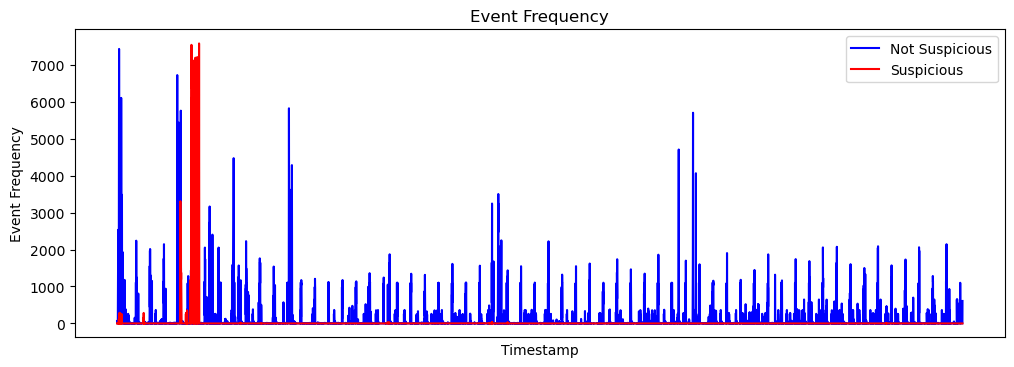

In [18]:
bins = pd.cut(dataset['timestamp'], bins=10000)
event_counts_notsus = dataset[dataset['sus']==0].groupby(bins).size()
event_counts_sus = dataset[dataset['sus']==1].groupby(bins).size()
event_counts_notsus.plot(kind='line', color='blue', label='Not Suspicious', figsize=(12, 4))
event_counts_sus.plot(kind='line', color='red', label='Suspicious')
plt.xlabel('Timestamp')
plt.ylabel('Event Frequency')
plt.title('Event Frequency')
plt.xticks([])
plt.legend()
plt.show()

In [19]:
def merge_sequences(df):
    return df.assign(
        # create a new col called separator with only NaNs
        separator=np.nan
        # create a stack series and convert it back into a dataframe with the cxorrect formatting
        ).stack(dropna=False).to_frame().reset_index(drop=True).rename({0: "centroid"}, axis=1)

In [20]:
sus = merge_sequences(dataset[dataset['sus']==1])

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_13284\1375280662.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return df.assign(


In [21]:
notsus = merge_sequences(dataset[dataset['sus']==0])

C:\Users\MORYBA.KOUATE\AppData\Local\Temp\ipykernel_13284\1375280662.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  return df.assign(


In [22]:
#fig, ax = plt.subplots(2,figsize=(24,8),sharex=True)
#ax[0].set_title('OS')
#ax[0].plot(OS)
#ax[1].set_title('Not_OS')
#ax[1].plot(Not_OS)

In [23]:
sus

,centroid
0,128.548679
1,1.000000
2,1.000000
3,1.000000
4,0.000000
...,...
1735135,4.000000
1735136,2.000000
1735137,0.000000
1735138,1.000000


In [24]:
sus.isna().sum()

centroid    173514
dtype: int64

In [25]:
sus['centroid'] = sus['centroid'].fillna(sus['centroid'].mean())

In [26]:
sus.isna().sum()

centroid    0
dtype: int64

In [27]:
notsus.isna().sum()

centroid    967564
dtype: int64

In [28]:
notsus['centroid'] = notsus['centroid'].fillna(notsus['centroid'].mean())

In [29]:
notsus.isna().sum()

centroid    0
dtype: int64

In [30]:
sus_part = sus.head(200000)

In [31]:
notsus_part = notsus.head(200000)

In [32]:
m = 2000
profile_sus_sus = stumpy.stump(sus_part['centroid'], m)[:, 0].astype(float)

In [33]:
profile_sus_notsus = stumpy.stump(sus_part['centroid'].astype(float), m, notsus_part['centroid'].astype(float), ignore_trivial=False)[:, 0].astype(float)

In [34]:
import seaborn as sns

C:\Users\MORYBA.KOUATE\.conda\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\MORYBA.KOUATE\.conda\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: >

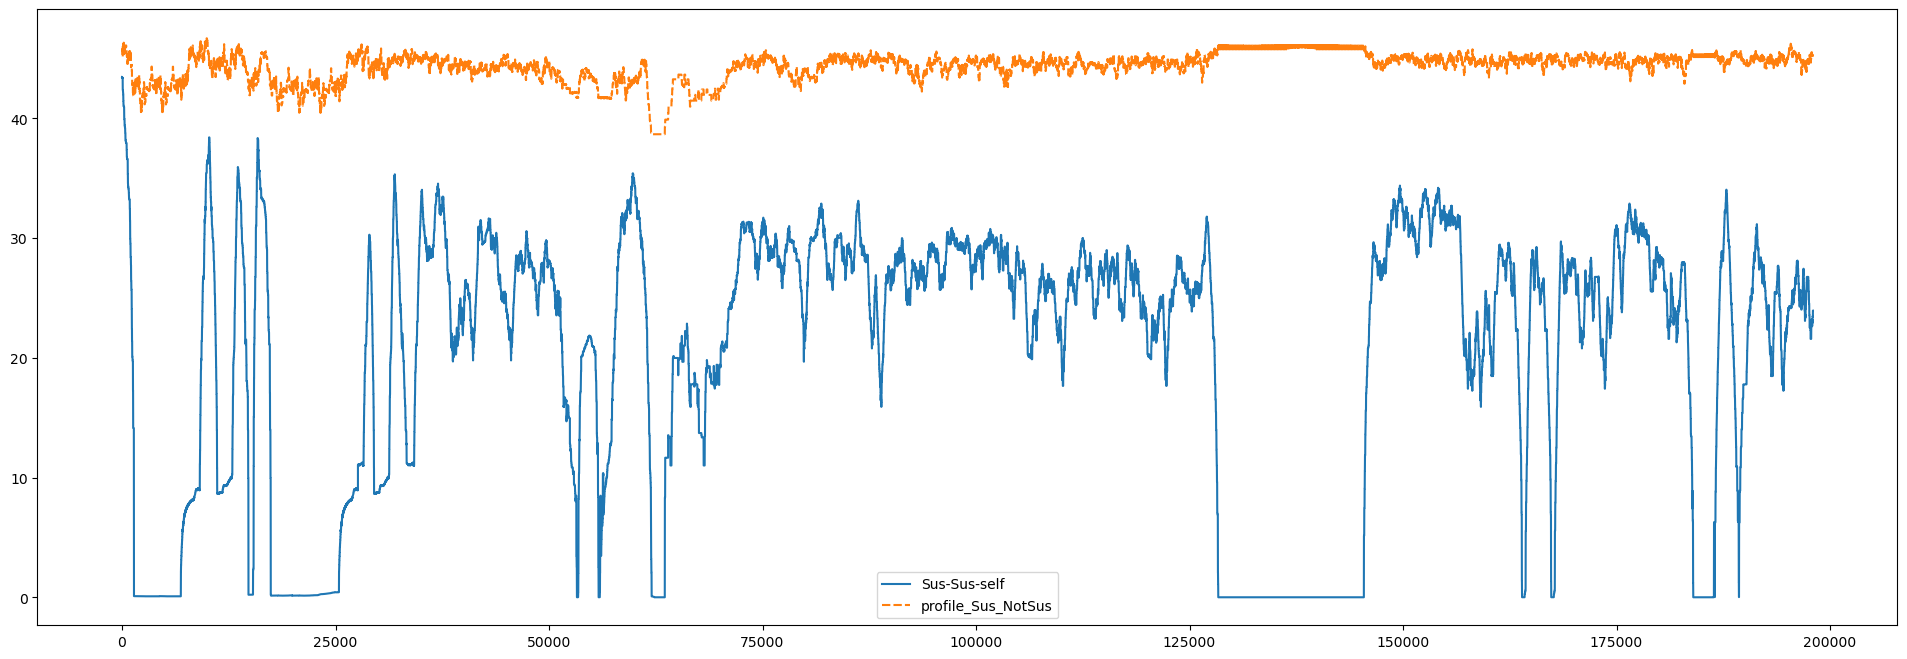

In [35]:
fig, ax = plt.subplots(figsize=(24,8))
sns.lineplot(data={'Sus-Sus-self':profile_sus_sus,'profile_Sus_NotSus':profile_sus_notsus}, ax=ax)

In [41]:
profile_diff = profile_sus_notsus - profile_sus_sus

In [42]:
profile_diff

array([ 2.47923829,  2.47936945,  2.47936945, ..., 21.21512512,
       21.21512512, 21.21512512])

In [38]:
worst_matches = np.argpartition(profile_diff,-10)[-10:]

In [39]:
worst_matches

array([142658, 143168, 142149, 142148, 141638, 141639, 143170, 141640,
       143169, 142150], dtype=int64)

# Building a Shapelet Based Model

In [43]:
from sklearn.model_selection import train_test_split

In [44]:
dataset

,timestamp,processId,parentProcessId,userId,mountNamespace,eventId,argsNum,returnValue,sus
0,124.439221,1,0,0,1,41,3,1,0
1,124.439751,1,0,0,1,41,3,1,0
2,124.439958,0,0,0,0,1005,4,0,0
3,124.440007,0,0,0,0,257,4,1,0
4,124.440037,0,0,0,0,5,2,0,0
...,...,...,...,...,...,...,...,...,...
1141073,3954.587254,0,0,0,0,257,4,1,0
1141074,3954.587429,0,0,0,0,5,2,0,0
1141075,3954.587480,0,0,0,0,217,3,1,0
1141076,3954.587526,0,0,0,0,217,3,0,0


In [ ]:
def get_shapelet_distance(shapelet, train):
    X = []
    for s, sample in enumerate(train):
        D = stumpy.mass(shapelet, sample)
        X.append(D.min())

    return np.array(X).reshape(-1,1)

In [ ]:
reference_shapelet = OS_shapelets[0].values